[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/mohnabilfadl/Airline_sentiment_analysis/blob/main/Airline_sentiment_analysis.ipynb)


**This notebook for implementing  sentiment anaylsis using different models from A to Z**

# Import libraries


In [98]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import callbacks

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


import joblib
import warnings


warnings.filterwarnings('ignore')
sns.set_theme()

# Data anaylsis

In [ ]:
Path = '/content/drive/MyDrive/Projects/Twitter US Airline Sentiment/Data/Tweets.csv'
raw_data = pd.read_csv(Path)
raw_data.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
raw_data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
data = raw_data[['text', 'airline_sentiment']]
data.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
data.rename({'text': 'tweet', 'airline_sentiment':'sentiment'}, axis=1, inplace=True)
data.head(5)

,tweet,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
data['sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [ ]:
data['sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: sentiment, dtype: int64

In [ ]:
data.isna().sum()

tweet        0
sentiment    0
dtype: int64

# Data preprocessing

In [ ]:
# clean text

def preprocesing_text(text):  
    text = text.lower()    
    text = re.sub('https?://[A-Za-z0-9./]+', ' ', text)   #remove url links
    text = re.sub("www.[A-Za-z0-9./]+", ' ', text)        #remove url links
    text = re.sub('@[^\s]+', ' ', text)     #remove user name
    text = re.sub('\d+', ' ', text)         #remove digits
    text = re.sub(r'[^\w\s]+', ' ', text)   #remove punctuations
    text = re.sub('_+', ' ', text)          #remove _ char
    text = re.sub('\n', ' ', text)          #convert to one line only
    text = re.sub(r'\b\w{1,2}\b', '', text) #remove words < 2
    text = re.sub(' +', ' ', text)          #convert two or more spaces into one space
    return text


In [ ]:
data['text']=data['tweet'].apply(preprocesing_text)
data.head()

,tweet,sentiment,text
0,@VirginAmerica What @dhepburn said.,neutral,what said
1,@VirginAmerica plus you've added commercials t...,positive,plus you added commercials the experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,neutral,didn today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,negative,really aggressive blast obnoxious entertainme...
4,@VirginAmerica and it's a really big bad thing...,negative,and really big bad thing about


In [ ]:
# save preprocessed data to new csv
# data = data[['text', 'sentiment']]
# data.to_csv('tweets_processed.csv', index=False)

# Data visualization

In [ ]:
labels = ['negative','neutral','positive']
values = data['sentiment'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(height=500, width=500, paper_bgcolor="grey")
fig.show()

In [ ]:
fig = px.histogram(data, x=data['text'].str.len(), title='Tweet length vs Tweets count ')
fig.update_layout(height=500, width=800, paper_bgcolor="grey")
fig.show()

In [ ]:
# Word cloud 
def wordCloud(sentiment):
    df = data[data['sentiment'] == sentiment]
    text = " ".join(review for review in df.text)
    wordcloud = WordCloud(background_color='black',height = 600, width = 800).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

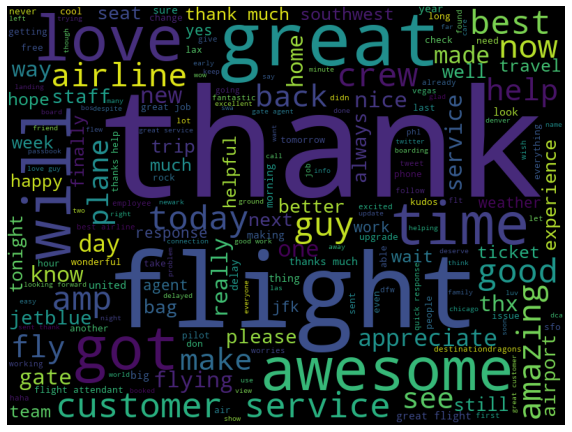

In [ ]:
# most positive words
wordCloud('positive')

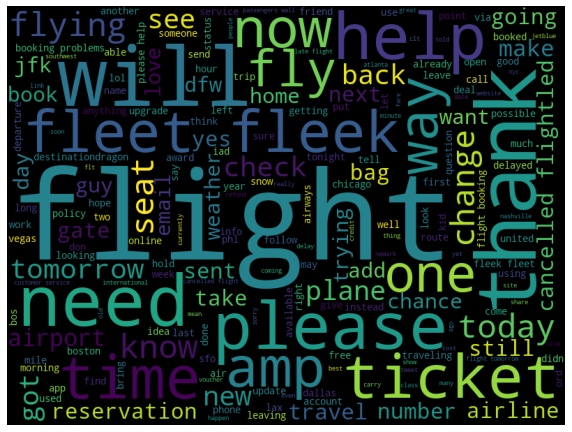

In [ ]:
# most neutral words
wordCloud('neutral')

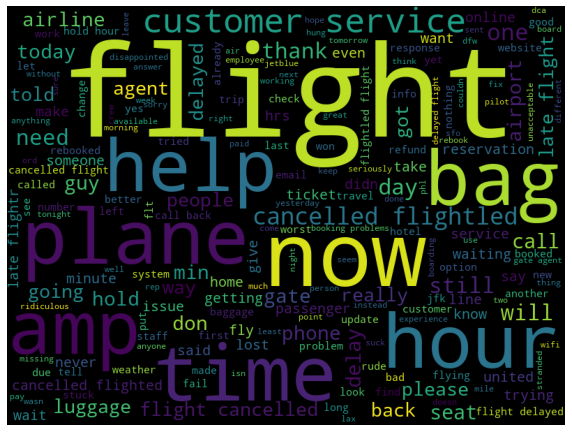

In [ ]:
# most negative words
wordCloud('negative')

# Data splitting

In [2]:
Path = '/content/drive/MyDrive/Projects/Twitter US Airline Sentiment/Data/tweets_processed.csv'
df = pd.read_csv(Path)
df.head(5)

,text,sentiment
0,what said,neutral
1,plus you added commercials the experience tacky,positive
2,didn today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainme...,negative
4,and really big bad thing about,negative


In [ ]:
df.shape

(14640, 2)

In [3]:
X = df.drop('sentiment', inplace=False, axis=1)
y = df['sentiment']

In [4]:
# split the data into train, validation, and test set

def train_val_test_split(X, y, train_size, val_size, test_size):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_size, random_state=42)

    relative_train_size = train_size / (val_size + train_size)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      train_size = relative_train_size, test_size = 1-relative_train_size,
                                                      random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [5]:
X_train, X_val, X_test, y_train, y_val, y_test=train_val_test_split(X, y, .6, .2, .2)

In [ ]:
print('training features size: '+str(X_train.shape)+", validation features size: "+ str(X_val.shape)+", testing features size: "+str(X_test.shape))
print('training labels size: '+str(y_train.shape)+", validation labels size: "+str(y_val.shape)+ ", testing labels size: "+str(y_test.shape))

training features size: (8783, 1), validation features size: (2929, 1), testing features size: (2928, 1)
training labels size: (8783,), validation labels size: (2929,), testing labels size: (2928,)


# Train traditional machine learning models

In [6]:
# Text to Vector using tf-idf

vec = TfidfVectorizer(ngram_range=(1, 2), max_df=.8, min_df=1, max_features=1000)

In [7]:
X_train_vec = vec.fit_transform(X_train['text'].apply(lambda x: np.str_(x))).toarray()
X_val_vec = vec.transform(X_val['text'].apply(lambda x: np.str_(x))).toarray()
X_test_vec = vec.transform(X_test['text'].apply(lambda x: np.str_(x))).toarray()

In [8]:
# Encode labels

enc = {'positive': 1, 'negative': 0, 'neutral': 2}

y_train_vec = y_train.map(enc).to_numpy()
y_val_vec = y_val.map(enc).to_numpy()
y_test_vec = y_test.map(enc).to_numpy()

In [ ]:
print('X_train size:', X_train_vec.shape)
print('y_train size:', y_train_vec.shape)
print('X_val size:', X_val_vec.shape)
print('y_val size:', y_val_vec.shape)
print('X_test size:', X_test_vec.shape)
print('y_test size:', y_test_vec.shape)

X_train size: (8783, 1000)
y_train size: (8783,)
X_val size: (2929, 1000)
y_val size: (2929,)
X_test size: (2928, 1000)
y_test size: (2928,)


## 1. Logistic Regression



In [ ]:
model_lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs','liblinear']  
penalty = ['l2']
max_iter=[200]
c_values = [0.001, 0.01, 0.1, 1, 10, 100]

grid_lr = dict(solver=solvers, penalty=penalty, C=c_values, max_iter=max_iter)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [ ]:
HGS_lr = HalvingGridSearchCV(estimator=model_lr, param_grid=grid_lr, n_jobs=-1, cv=cv, scoring='accuracy')
result_lr = HGS_lr.fit(X_train_vec, y_train_vec)

In [ ]:
print(result_lr.best_score_)
print(result_lr.best_params_)

0.7784119431104001
{'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=1, max_iter=200, solver='newton-cg')


In [ ]:
model_lr = result_lr.best_estimator_

In [ ]:
# save model
joblib.dump(model_lr, "LR_MODEL.pkl")

['LR_MODEL.pkl']

## 2. Naive Bayes

In [ ]:
model_nb = MultinomialNB()
alpha = [ 0.001, 0.01, 0.1, 1, 1.5, 2.0] 

grid_nb = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [ ]:
HGS_nb = HalvingGridSearchCV(estimator=model_nb, param_grid=grid_nb, n_jobs=-1, cv=cv, scoring='accuracy')
result_nb = HGS_nb.fit(X_train_vec, y_train_vec)

In [ ]:
print(result_nb.best_score_)
print(result_nb.best_params_)

0.7459628886008682
{'alpha': 0.1}


In [ ]:
model_nb = result_nb.best_estimator_

In [ ]:
# save model
joblib.dump(model_nb, "NB_MODEL.pkl")

['NB_MODEL.pkl']

# Train using deep learning models

In [87]:
# copy data
X_ntrain, X_nval, X_ntest, y_ntrain, y_nval, y_ntest = X_train, X_val, X_test, y_train, y_val, y_test

# squeeze data to be 1-dim
X_ntrain = np.squeeze(X_ntrain)
X_nval = np.squeeze(X_nval)
X_ntest = np.squeeze(X_ntest)

In [88]:
# Tokenize our training data

t = Tokenizer(num_words=1000, oov_token='<UNK>')
t.fit_on_texts(X_ntrain)

In [ ]:
# Get our training data word index

word_index = t.word_index
# print("Word index:\n", word_index)

In [90]:
# Vocab size

vocab_size = len(t.word_index) + 1
print(vocab_size)

8502


In [91]:
# Encode data sentences into sequences

X_ntrain = t.texts_to_sequences(X_ntrain)
X_nval = t.texts_to_sequences(X_nval)
X_ntest = t.texts_to_sequences(X_ntest)

In [92]:
# Get max training sequence length

maxlen = max([len(x) for x in X_ntrain])
print(maxlen)

24


In [93]:
# Pad the sequences
X_ntrain = pad_sequences(X_ntrain, padding="post", maxlen=50)
X_nval = pad_sequences(X_nval, padding="post", maxlen=50)
X_ntest = pad_sequences(X_ntest, padding="post", maxlen=50)

In [94]:
# Encode labels
lb =LabelEncoder()
# negative:0, neutral:1, positive:2

y_ntrain = lb.fit_transform(y_ntrain)
y_nval = lb.transform(y_nval)
y_ntest = lb.transform(y_ntest)


In [95]:
# One hot encoding

y_ntrain = to_categorical(y_ntrain)
y_nval = to_categorical(y_nval)
y_ntest = to_categorical(y_ntest)

In [ ]:
print('X_train size:', X_ntrain.shape)
print('y_train size:', y_ntrain.shape)
print('X_val size:', X_nval.shape)
print('y_val size:', y_nval.shape)
print('X_test size:', X_ntest.shape)
print('y_test size:', y_ntest.shape)

X_train size: (8783, 50)
y_train size: (8783, 3)
X_val size: (2929, 50)
y_val size: (2929, 3)
X_test size: (2928, 50)
y_test size: (2928, 3)


In [ ]:
# Embeddings using glove

path = '/content/drive/MyDrive/Projects/Twitter US Airline Sentiment/Glove/glove.6B.100d.txt'

embeddings_index = {}
f = open(path, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# fill in matrix of embedding for each word in the training dataset.
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrixb
        embedding_matrix[i] = embedding_vector # each row of matrix

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           850200    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,087,299
Trainable params: 237,099
Non-trainable params: 850,200
_________________________________________________________________


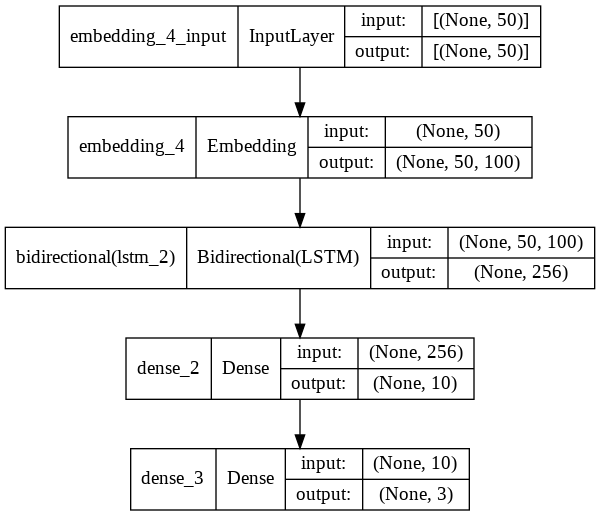

In [ ]:
# Create model

model_lst = Sequential()
model_lst.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = 50, trainable=False))

model_lst.add(Bidirectional(LSTM(128)))
model_lst.add(Dense(10, activation='relu'))
model_lst.add(Dense(3, activation='softmax'))

model_lst.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model_lst.summary()
plot_model(model_lst, show_shapes=True, show_layer_names=True)

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_acc', patience=5)

history = model_lst.fit(X_ntrain, y_ntrain, epochs=20, batch_size=256,
                       validation_data=(X_nval, y_nval), callbacks=[callback])

Epoch 1/20
35/35 [==============================] - 21s 500ms/step - loss: 0.8402 - acc: 0.6427 - val_loss: 0.7342 - val_acc: 0.6968
Epoch 2/20
35/35 [==============================] - 17s 472ms/step - loss: 0.6755 - acc: 0.7283 - val_loss: 0.6664 - val_acc: 0.7289
Epoch 3/20
35/35 [==============================] - 16s 465ms/step - loss: 0.6213 - acc: 0.7451 - val_loss: 0.6450 - val_acc: 0.7381
Epoch 4/20
35/35 [==============================] - 16s 466ms/step - loss: 0.5914 - acc: 0.7540 - val_loss: 0.6313 - val_acc: 0.7436
Epoch 5/20
35/35 [==============================] - 16s 467ms/step - loss: 0.5823 - acc: 0.7642 - val_loss: 0.6449 - val_acc: 0.7453
Epoch 6/20
35/35 [==============================] - 16s 468ms/step - loss: 0.5625 - acc: 0.7715 - val_loss: 0.6072 - val_acc: 0.7525
Epoch 7/20
35/35 [==============================] - 16s 466ms/step - loss: 0.5594 - acc: 0.7733 - val_loss: 0.6299 - val_acc: 0.7480
Epoch 8/20
35/35 [==============================] - 16s 471ms/step - 

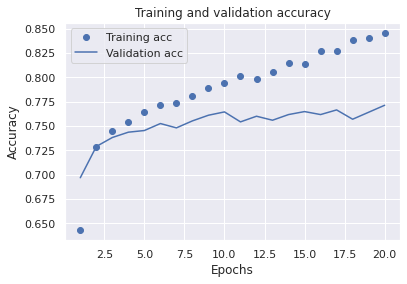

In [ ]:
# Draw Training and validation accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# save model
joblib.dump(model_lst, "LST_MODEL.pkl")

INFO:tensorflow:Assets written to: ram://87bc59e4-4e3f-498b-b604-9dd3c8ee71e9/assets


INFO:tensorflow:Assets written to: ram://87bc59e4-4e3f-498b-b604-9dd3c8ee71e9/assets


['LST_MODEL.pkl']

# Overall validation

In [60]:
# validate 3 models logistic regression, naive bayes and lstm neural network
# load 3 models 
lr = joblib.load('/content/drive/MyDrive/Projects/Twitter US Airline Sentiment/Models/LR_MODEL.pkl')
nb = joblib.load('/content/drive/MyDrive/Projects/Twitter US Airline Sentiment/Models/NB_MODEL.pkl')
lstm = joblib.load('/content/drive/MyDrive/Projects/Twitter US Airline Sentiment/Models/LSTM_MODEL.pkl')

In [49]:
# Fuunction to validate machine learning models
def ml_evaluate(model, X_features, y_labels):
  y_pred = model.predict(X_features)

  accuracy = round(accuracy_score(y_labels, y_pred), 4)
  precision = round(precision_score(y_labels, y_pred, average='micro'), 4)
  recall = round(recall_score(y_labels, y_pred, average='micro'), 4)
  f1 = round(f1_score(y_labels, y_pred, average='micro'), 4)

  return ('accuracy: {} / Precision: {} / recall: {} / f1_score: {}'.format(accuracy, precision, recall, f1))

In [50]:
# Fuunction to validate deep learning models
def dl_evaluate(model, X_features, y_labels):
  y_pred = model.predict(X_features)
  y_pred = np.argmax(y_pred, axis=1)
  y_labels = np.argmax(y_labels, axis=1)
  
  accuracy = round(accuracy_score(y_labels, y_pred), 4)
  precision = round(precision_score(y_labels, y_pred, average='micro'), 4)
  recall = round(recall_score(y_labels, y_pred, average='micro'), 4)
  f1 = round(f1_score(y_labels, y_pred, average='micro'), 4)

  return ('accuracy: {} / Precision: {} / recall: {} / f1_score: {}'.format(accuracy, precision, recall, f1))

In [55]:
print("Logistic regression: " + ml_evaluate(lr, X_val_vec, y_val_vec))
print('--------------------------------------------------------------------')
print("Naive bayes: " + ml_evaluate(nb, X_val_vec, y_val_vec))
print('--------------------------------------------------------------------')
print("Neural network: " + dl_evaluate(lstm, X_nval, y_nval))

Logistic regression: accuracy: 0.7658 / Precision: 0.7658 / recall: 0.7658 / f1_score: 0.7658
--------------------------------------------------------------------
Naive bayes: accuracy: 0.7357 / Precision: 0.7357 / recall: 0.7357 / f1_score: 0.7357
--------------------------------------------------------------------
Neural network: accuracy: 0.7713 / Precision: 0.7713 / recall: 0.7713 / f1_score: 0.7713


**So We noticed that neural network model is the best model**

# Test using the best model

In [96]:
# Classification Report
y_pred = lstm.predict(X_ntest)

y_pred = np.argmax(y_pred, axis=1)
y_ntest = np.argmax(y_ntest, axis=1)

print(classification_report(y_ntest, y_pred, target_names = ['negative','neutral','positive']))

              precision    recall  f1-score   support

    negative       0.83      0.90      0.87      1889
     neutral       0.62      0.49      0.55       580
    positive       0.72      0.66      0.69       459

    accuracy                           0.78      2928
   macro avg       0.72      0.69      0.70      2928
weighted avg       0.77      0.78      0.78      2928



In [99]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_ntest, y_pred)

print(cf_matrix)

[[1706  123   60]
 [ 238  287   55]
 [ 101   56  302]]


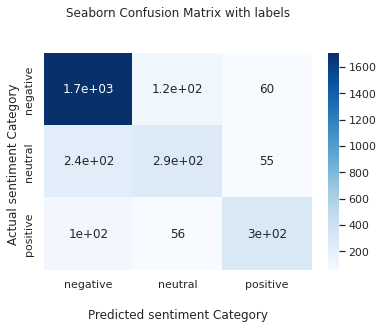

In [100]:
# Draw the confusion matrix
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted sentiment Category')
ax.set_ylabel('Actual sentiment Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['negative','neutral', 'positive'])
ax.yaxis.set_ticklabels(['negative','neutral', 'positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

# End
# **By Mohamed Fadl**